In [2]:
import numpy as np
from fairlearn.datasets import fetch_acs_income
from sklearn import preprocessing
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import equalized_odds_difference
import numpy as np
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource

from privacy_meter import audit_report
from privacy_meter.audit_report import *

import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
# load dataset
import pandas as pd
from fairlearn.reductions import EqualizedOdds
import warnings
warnings.filterwarnings('ignore')

from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import Fairlearn_Model, Sklearn_Model
import os
from torch.utils.data import TensorDataset, DataLoader

from fairtorch import ConstraintLoss, DemographicParityLoss, EqualiedOddsLoss
import random
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

2023-04-17 22:30:31.021963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 22:30:31.137275: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu::/usr/lib/x86_64-linux-gnu:
2023-04-17 22:30:31.137289: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-17 22:30:31.681938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: 

In [155]:
from privacy_meter.model import PytorchModelTensor
from privacy_meter.dataset import Dataset
import scipy
def compute_p_value( target_value, observed_distribution):
    return scipy.stats.percentileofscore(observed_distribution, target_value)/100

# import copy
import time
def privacy_evaluation(target_model, train_ds, test_ds, population_ds, g_train, g_test, g_population):
    target_model = PytorchModelTensor(target_model, nn.BCEWithLogitsLoss(reduction='none'))
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )
    reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='x', default_output='y', default_group='g'
    )
    target_info_source = InformationSource(
    models=[target_model], 
        datasets=[target_dataset]
    )

    reference_info_source = InformationSource(
        models=[target_model],
        datasets=[reference_dataset]
    )
    audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    logs_directory_names='log_'+str(time.time())
    )
    audit_obj.prepare()

    train_signal = audit_obj.metric_objects[0].member_signals
    test_signal = audit_obj.metric_objects[0].non_member_signals
    pop_signal = audit_obj.metric_objects[0].reference_signals
    

    p_results = {}
    for idx, g in enumerate(torch.unique(g_train)):
        un_pop = pop_signal[g_pop==g]
        p_train = compute_p_value(train_signal[g_train==g], un_pop)
        p_test = compute_p_value(test_signal[g_test==g], un_pop)
        p_results[idx] = {}
        p_results[idx]['p'] = np.concatenate([p_train, p_test])
        p_results[idx]['mem'] = np.concatenate([np.ones(len(p_train)), np.zeros(len(p_test))])
        
    return p_results
        



In [156]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(2020)

In [157]:

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    
def get_data(N):
    p00 = 0.02
    p10 = 0.4
    p11 = 0.4
    p01 = 0.18

    X00 = np.random.multivariate_normal([0, -1], [[7, 1], [1, 7]], int(N*p00))
    X01 = np.random.multivariate_normal([-5, 0], [[5, 1], [1, 5]], int(N*p01))
    X10 = np.random.multivariate_normal([1, 2], [[5, 2], [2, 5]], int(N*p10))
    X11 = np.random.multivariate_normal([2, 3], [[10, 1], [1, 4]], int(N*p11))
    X = np.concatenate((X00, X01, X10, X11), axis=0)
    y_true = np.concatenate((np.zeros(int(N*p00)), np.ones(int(N*p01)), np.zeros(int(N*p10)), np.ones(int(N*p11))), axis=0)
    sex = np.concatenate((np.ones(int(N*p00)), np.ones(int(N*p01)), np.full(int(N*p10), 2), np.full(int(N*p11), 2)), axis=0)
    return X, y_true, sex

def inference(model,X,y,sensi):
    y_pred = (torch.sigmoid(model(X)).view(-1) > 0.5 ).float()

    expect_by_a={}

    # for i in [1, 2]:
    #     # print(sensi_test.shape, y_pred.shape)
    #     idx = sensi==i
    #     expect_by_a[i]=  y_pred[idx].mean().item()
    # print(expect_by_a)
    # vanilla_gap_dp = np.abs(expect_by_a[1] - expect_by_a[2])
    # # print("gap: ",vanilla_gap_dp)

    expect_by_a_y = {}
    expect_by_a_y_list = []
    for i in [1, 2]:
        expect_by_a_y[i]={}
        for j in [0, 1]:
            idx= (sensi == i) & (y == j)
            expc = y_pred[idx].mean().item()
            expect_by_a_y[i][j] =  expc
            expect_by_a_y_list.append(expc)
    # print(expect_by_a_y)
    vanilla_gap_eo = np.max(expect_by_a_y_list)- np.min(expect_by_a_y_list)
    print("gap: ", vanilla_gap_eo)

# Load data

In [158]:
# # Load dataset 
# data = fetch_acs_income(as_frame=False,states=["CA"])
# sex = data.data[:,data['feature_names'].index('SEX')]
# X = data.data
# y_true = (data.target > 50000) * 1
# X = preprocessing.normalize(X, norm='l2')

# device = 'cuda:0'

# num_train_points = 1000
# num_test_points = 1000


# num_fair_train_points = 10000
# num_population_points = 30000

# train_index = np.random.choice(X.shape[0], num_train_points, replace=False)
# test_index = np.random.choice(X.shape[0], num_test_points, replace=False)
# fair_train_index = np.random.choice(X.shape[0], num_fair_train_points, replace=False)
# population_index = np.random.choice(X.shape[0], num_population_points, replace=False)

In [205]:
device = 'cuda:0'
num_train_points = 1000
num_test_points = 1000
num_population_points = 30000
X_train,y_train, g_train = get_data(num_train_points)
X_test ,y_test, g_test = get_data(num_test_points)
X_population, y_population, g_population = get_data(num_population_points)
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
sensi_train = torch.from_numpy(g_train).float()
sensi_test = torch.from_numpy(g_test).float()
# create the target model's dataset
g_train  = y_train+ sensi_train*2
g_test  = y_test+ sensi_test*2


X_population = torch.from_numpy(X_population).float()
y_population = torch.from_numpy(y_population).float()
sensi_population = torch.from_numpy(g_population).float()
g_population = y_population+ sensi_population*2



# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train, sensi_train)
test_dataset = TensorDataset(X_test, y_test, sensi_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
# X = np.concatenate((X_train, X_test, X_fair_train, X_population), axis=0)
# y_true = np.concatenate((y_train, y_test, y_fair_train, y_population), axis=0)
# sex = np.concatenate((g_train, g_test, g_fair_train, g_population), axis=0)

# train_index = np.arange(num_train_points)
# test_index = np.arange(num_train_points, num_train_points+num_test_points)
# fair_train_index = np.arange(num_train_points+num_test_points, num_train_points+num_test_points+num_fair_train_points)
# population_index = np.arange(num_train_points+num_test_points+num_fair_train_points, num_train_points+num_test_points+num_fair_train_points+num_population_points)

In [235]:
# Convert the data to tensors
num_fair_train_points = 10000
X_fair_train, y_fair_train, g_fair_train = get_data(num_fair_train_points)
X_fair_train = torch.from_numpy(X_fair_train).float()
y_fair_train = torch.from_numpy(y_fair_train).float()
sensi_fair = torch.from_numpy(g_fair_train).float()
g_fair_train = y_fair_train+ sensi_fair*2

fair_train_dataset = TensorDataset(X_fair_train, y_fair_train, sensi_fair)

fair_train_loader =  DataLoader(fair_train_dataset, batch_size=len(fair_train_dataset), shuffle=False)


In [236]:
num_epochs=1000

In [237]:
def train(input_shape, alpha, coff, device, train_loader,X_train, y_train, X_test, y_test, num_epochs=1000,fair_train_loader=None):
    model = Model(input_shape, 1024, 1)
    if coff!=0:
        dp_loss = EqualiedOddsLoss(sensitive_classes=[1, 2], alpha=alpha)
    optimizer = optim.AdamW(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)
    for name, param in model.named_parameters():
        if 'weight' in name:
            nn.init.xavier_normal_(param)
    
    model.train()
    for epoch in range(num_epochs):
        for i, (x, y, s) in enumerate(train_loader):
            lossfair = 0
            optimizer.zero_grad()  
            x, y, s = x.to(device), y.to(device), s.to(device)
            logit = model(x)
            loss = criterion(logit.view(-1), y)
            if coff!=0:
                if fair_train_loader is not None:
                    for (x_f, y_f, s_f) in fair_train_loader:
                        # print(x_f.shape, y_f.shape, s_f.shape)
                        x_f, y_f, s_f = x_f.to(device), y_f.to(device), s_f.to(device)
                        logit_f = model(x_f)
                        lossfair += dp_loss(x_f, logit_f, s_f, y_f)
                else:
                    lossfair = dp_loss(x, logit, s, y)
                if torch.isnan(lossfair):
                    loss = loss
                else:
                    loss = loss + lossfair
            
            loss.backward()
            optimizer.step()
            # Print progress
            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    model.to('cpu')
    return model


def inference(model,X,y,sensi):
    y_pred = (torch.sigmoid(model(X)).view(-1) > 0.5 ).float()

    expect_by_a={}

    # for i in [1, 2]:
    #     # print(sensi_test.shape, y_pred.shape)
    #     idx = sensi==i
    #     expect_by_a[i]=  y_pred[idx].mean().item()
    # print(expect_by_a)
    # vanilla_gap_dp = np.abs(expect_by_a[1] - expect_by_a[2])
    # # print("gap: ",vanilla_gap_dp)

    expect_by_a_y = {}
    expect_by_a_y_list = []
    for i in [1, 2]:
        expect_by_a_y[i]={}
        for j in [0, 1]:
            idx= (sensi == i) & (y == j)
            expc = y_pred[idx].mean().item()
            expect_by_a_y[i][j] =  expc
            expect_by_a_y_list.append(expc)
    # print(expect_by_a_y)
    vanilla_gap_eo = np.max(expect_by_a_y_list)- np.min(expect_by_a_y_list)
    acc = ((torch.sigmoid(model(X)).view(-1) > 0.5 ).float()  == y ).float().mean().float().item()
    # print("acc: ",round(acc,3))
    
    # print("gap: ", round(vanilla_gap_eo,3))
    return round(acc,3), round(vanilla_gap_eo,3)

In [238]:
fair_model2 = train(X_train.shape[1], 50, 1, device, train_loader, X_train, y_train, X_test, y_test,num_epochs=num_epochs,fair_train_loader=fair_train_loader)


In [ ]:
# model = train(X_train.shape[1], 0, 0, device, train_loader, X_train, y_train, X_test, y_test,num_epochs=num_epochs,fair_train_loader=None)
# fair_model = train(X_train.shape[1], 50, 1, device, train_loader, X_train, y_train, X_test, y_test,num_epochs=num_epochs,fair_train_loader=None)
# fair_model2 = train(X_train.shape[1], 50, 1, device, train_loader, X_train, y_train, X_test, y_test,num_epochs=num_epochs,fair_train_loader=fair_train_loader)



In [ ]:
un_test_acc, un_test_gap = inference(model,X_test,y_test, sensi_test)
fair_test_acc, fair_test_gap = inference(fair_model,X_test,y_test, sensi_test)
fair_test_acc2, fair_test_gap2 = inference(fair_model2,X_test,y_test, sensi_test)

un_train_acc, un_train_gap = inference(model,X_train,y_train, sensi_train)
fair_train_acc, fair_train_gap = inference(fair_model,X_train,y_train, sensi_train)
fair_train_acc2, fair_train_gap2 = inference(fair_model2,X_train,y_train, sensi_train)

In [ ]:
print(un_train_acc, '|',un_test_acc, '|',un_train_gap, '|',un_test_gap,'|')
print(fair_train_acc, '|',fair_test_acc, '|',fair_train_gap, '|',fair_test_gap,'|')
print(fair_train_acc2, '|',fair_test_acc2, '|',fair_train_gap2, '|',fair_test_gap2,'|')

0.755 | 0.641 | 0.761 | 0.405 |
0.58 | 0.58 | 0.0 | 0.0 |
0.688 | 0.623 | 0.594 | 0.328 |


# attack fair models and models


0 | 0.75 | 0.55 | 0.7
1 | 0.531 | 0.519 | 0.556
2 | 0.605 | 0.509 | 0.556
3 | 0.562 | 0.512 | 0.541


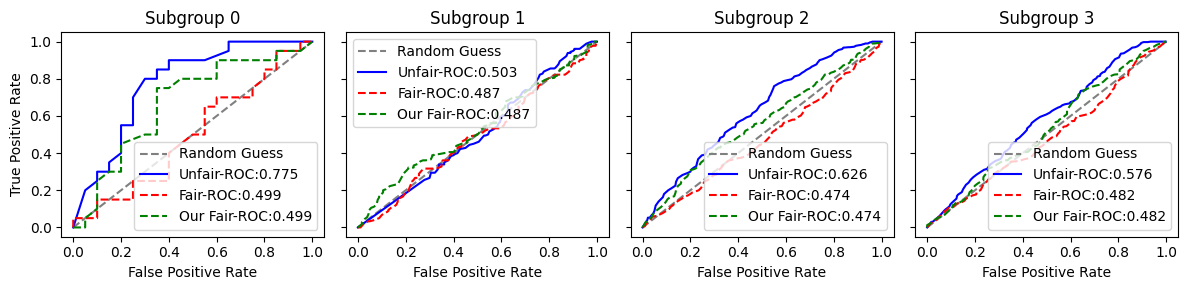

In [ ]:
# create the target model's dataset
train_ds = {'x': X_train, 'y': y_train.reshape(-1,1),'g':sensi_train}
test_ds = {'x': X_test, 'y': y_test.reshape(-1,1), 'g':sensi_test}
population_ds = {'x': X_population, 'y': y_population.reshape(-1,1), 'g': sensi_population}

p_results = privacy_evaluation(model,train_ds, test_ds, population_ds, g_train, g_test, g_population)
p_fair_results = privacy_evaluation(fair_model, train_ds, test_ds, population_ds, g_train, g_test, g_population)
p_fair_results_2 = privacy_evaluation(fair_model2, train_ds, test_ds, population_ds, g_train, g_test, g_population)


figs, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)

# group = np.unique(g_train)
for idx, group in enumerate(np.unique(g_train)):
    tpr = [np.mean(p_results[idx]['p'][p_results[idx]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fpr = [np.mean(p_results[idx]['p'][p_results[idx]['mem']==0]<i) for i in np.linspace(0,1,100)]

    fair_tpr = [np.mean(p_fair_results[idx]['p'][p_fair_results[idx]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fair_fpr = [np.mean(p_fair_results[idx]['p'][p_fair_results[idx]['mem']==0]<i) for i in np.linspace(0,1,100)]

    fair_tpr2 = [np.mean(p_fair_results_2[idx]['p'][p_fair_results_2[idx]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fair_fpr2 = [np.mean(p_fair_results_2[idx]['p'][p_fair_results_2[idx]['mem']==0]<i) for i in np.linspace(0,1,100)]


    roc = np.trapz(tpr, fpr)
    fair_roc = np.trapz(fair_tpr, fair_fpr)
    print(idx, '|', round(max(np.array(tpr) + (1-np.array(fpr)))/2,3), '|',round(max(np.array(fair_tpr) + (1-np.array(fair_fpr)))/2,3), '|',round(max(np.array(fair_tpr2) + (1-np.array(fair_fpr2)))/2,3))
    axes[idx].plot([0, 1], [0, 1], 'k--', label='Random Guess', color='grey')
    axes[idx].plot(fpr, tpr, label=f'Unfair-ROC:{roc:.3f}', color='blue')
    axes[idx].plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_roc:.3f}', ls='--', color='red')
    axes[idx].plot(fair_fpr2, fair_tpr2, label=f'Our Fair-ROC:{fair_roc:.3f}', ls='--', color='green')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_title(f'Subgroup {idx}')
    axes[idx].legend()
axes[0].set_ylabel('True Positive Rate')
plt.tight_layout()